In [39]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json

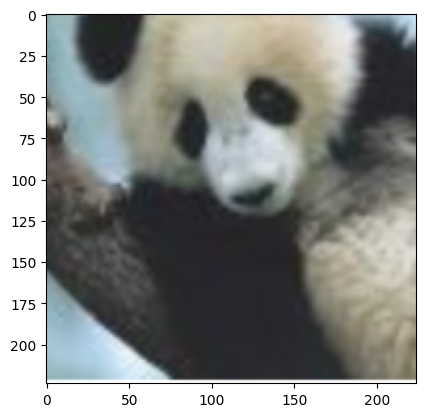

In [32]:
panda_img = Image.open("panda.png")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
panda_tensor = preprocess(panda_img)[None,:3,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(panda_tensor[0].numpy().transpose(1,2,0))

In [18]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


In [43]:
!wget https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json

--2024-04-17 10:56:06--  https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json [following]
--2024-04-17 10:56:06--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2024-04-17 10:56:06 (14.7 MB/s) - ‘imagenet_class_index

In [38]:
pred = model(norm(panda_tensor))

In [44]:
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

giant_panda


In [52]:
print(nn.CrossEntropyLoss()(model(norm(panda_tensor)),torch.LongTensor([388])).item())

0.18264688551425934


In [65]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(panda_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(panda_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([388]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,388].item())


0 -0.18264688551425934
5 -10.95656681060791
10 -19.386722564697266
15 -15.527474403381348
20 -19.644041061401367
25 -14.9865140914917
True class probability: 1.0744860645672816e-07


In [66]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  indri
Predicted probability: 0.9993860721588135


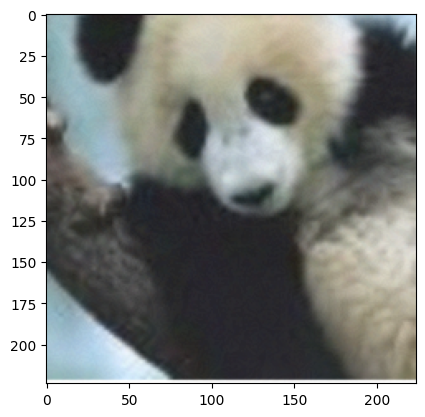

In [59]:
plt.imshow((panda_tensor + delta)[0].detach().numpy().transpose(1,2,0))

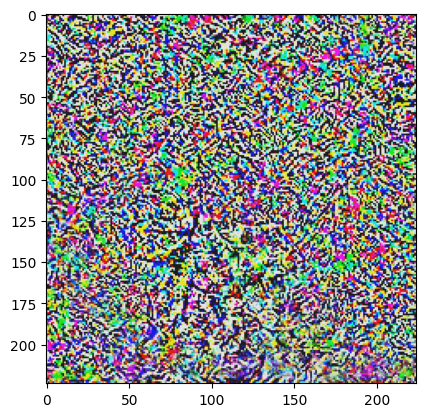

In [58]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [60]:
delta = torch.zeros_like(panda_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(panda_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([388])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)


0 11.715142250061035
10 -11.236062049865723
20 -32.71977615356445
30 -46.443626403808594
40 -54.73245620727539
50 -57.90680694580078
60 -63.49545669555664
70 -65.19319152832031
80 -70.73544311523438
90 -67.52588653564453


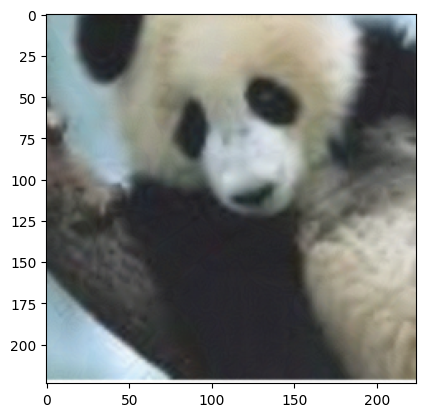

In [61]:
plt.imshow((panda_tensor + delta)[0].detach().numpy().transpose(1,2,0))

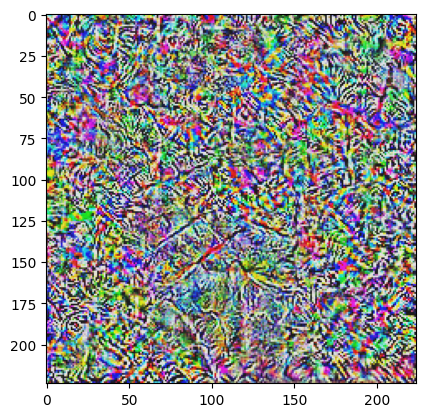

In [62]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [63]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9999942779541016


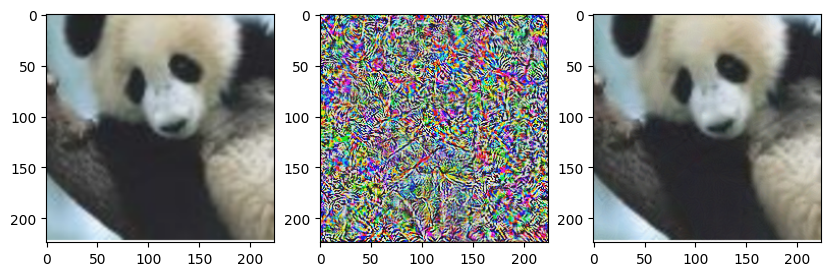

In [64]:
f,ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow((panda_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
ax[2].imshow((panda_tensor + delta)[0].detach().numpy().transpose(1,2,0))